In [ ]:
!pip install keras-unet

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

## Loading 2017 data

In [0]:
DATA_PATH = '../../data/processed'

def load_data(year, img_h=1400, img_w=1400):

    X = []
    y = []

    data_dir = os.path.join(DATA_PATH, str(year))
    frames_dir = os.path.join(data_dir, 'frames')
    masks_dir = os.path.join(data_dir, 'masks')

    for file in sorted(os.listdir(frames_dir)):
        if file.startswith('R'):
            filename = file.split('.')[0]

            frame = np.load(os.path.join(frames_dir, filename + '.npy'))
            mask = np.load(os.path.join(masks_dir, filename + '_labels.npy'))
            X.append(frame[:img_h, :img_w, :])
            y.append(mask[:img_h, :img_w])

    X = np.array(X)
    y = np.array(y)

    return X, y

## Cropping 512x512 image patches to feed into network

In [0]:
# from PIL import Image
from keras_unet.utils import get_patches

def get_img_patches(X, y):
  
  X_crops = []
  y_crops = []

  CROP_SIZE = 512

  for i, x in enumerate(X):
    x_sample = get_patches(
        img_arr=x, # required - array of images to be cropped
        size=CROP_SIZE, # default is 256
        stride=CROP_SIZE) # default is 256

    y_sample = get_patches(
      img_arr=y[i].reshape(HEIGHT,WIDTH,1), # required - array of images to be cropped
      size=CROP_SIZE, 
      stride=CROP_SIZE)

    X_crops.append(x_sample)
    y_crops.append(y_sample)
    
  X_crops = np.array(X_crops)
  y_crops = np.array(y_crops)
  
  return X_crops, y_crops

## Loading, standardizing and shaping data for training

In [0]:
def standardize(X):

  # flatten X to 2D array
  X_reshaped = X.reshape(-1, X.shape[-1])

  # standardize on columns
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X_reshaped)

  # reshape X to original shape
  X_final = X_scaled.reshape(X.shape)

  return X_final

In [0]:
X, y = load_data(year=2018)
X_scaled = standardize(X)
X_crops, y_crops = get_img_patches(X_scaled, y)

In [0]:
X_reshaped = X_crops.reshape(X_crops.shape[0] * X_crops.shape[1], 
                            X_crops.shape[2], 
                            X_crops.shape[3],  
                            X_crops.shape[4])

y_reshaped  = y_crops.reshape(y_crops.shape[0] * y_crops.shape[1], 
                            y_crops.shape[2], 
                            y_crops.shape[3],
                            1)

## Train/val split

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y_reshaped, test_size=0.2, shuffle=False)

print("x_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", X_val.shape)
print("y_val: ", y_val.shape)

x_train:  (96, 512, 512, 13)
y_train:  (96, 512, 512, 1)
x_val:  (24, 512, 512, 13)
y_val:  (24, 512, 512, 1)



## Prepare train generator with data augmentation

In [ ]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        horizontal_flip=True,
        vertical_flip=True,
    ))

## Initialize network

In [0]:
from keras_unet.models import custom_unet

input_shape = X_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    num_classes=1,
    dropout=0.3,
    num_layers=4
)

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 13) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 32) 3776        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 512, 512, 32) 128         conv2d_20[0][0]                  
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 512, 512, 32) 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

## Compile + train

In [0]:
from keras.callbacks import ModelCheckpoint

model_filename = '/content/drive/My Drive/Insight/models/model_v1.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [0]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=Adam(), 
    loss='binary_crossentropy',
    metrics=[iou]
)

## Training model

In [0]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[callback_checkpoint]
)

## Validation Results

In [0]:
y_pred = model.predict(X_val)
y_pred_binary = np.round_(y_pred, 0)

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def iou(confusion_matrix):
  tn, fp, fn, tp = confusion_matrix.ravel()
  
  iou = tp / (tp + fn + fp)
  return iou

cm = confusion_matrix(y_val.flatten(), y_pred_binary.flatten())

print('Accuracy: %.2f' % accuracy_score(y_pred_binary.flatten(), y_val.flatten()))
print('IoU: %.2f' % iou(cm))
print('Confusion Matrix: \n',cm)
print('Classification report:\n', classification_report(y_pred_binary.flatten(), y_val.flatten()))

Accuracy: 0.95
IoU: 0.80
Confusion Matrix: 
 [[4610931  225429]
 [ 117315 1337781]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96   4728246
         1.0       0.92      0.86      0.89   1563210

    accuracy                           0.95   6291456
   macro avg       0.94      0.92      0.93   6291456
weighted avg       0.94      0.95      0.94   6291456



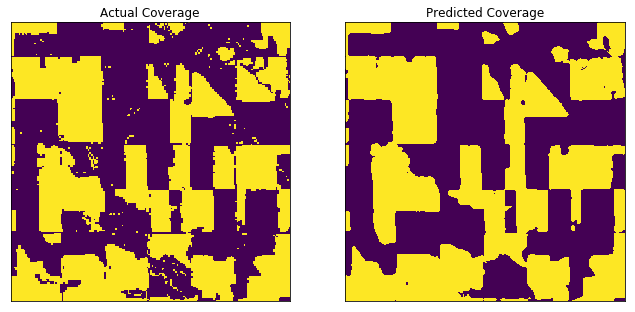

In [56]:
f = plt.figure(figsize=(11,6))

plt.subplot(121)
plt.title('Actual Coverage')
plt.xticks([])
plt.yticks([])
plt.imshow(y_val[0].reshape(512, 512))

plt.subplot(122)
plt.title('Predicted Coverage')
plt.xticks([])
plt.yticks([])
plt.imshow(y_pred_binary[0].reshape(512, 512))